In [1]:
# 0. 작업 준비
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch.utils import data
from torchvision import datasets, transforms, utils
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

tr_ds = datasets.MNIST(root='../data/',
                              train=True,
                              download=True,
                              transform=transform)

100%|██████████| 9.91M/9.91M [00:32<00:00, 301kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:05<00:00, 284kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.27MB/s]


In [4]:
BATCH_SIZE = 60000
tr_ds_loader = torch.utils.data.DataLoader(
    dataset = tr_ds,
    batch_size = BATCH_SIZE,
    shuffle = False
)
img, _ = next(iter(tr_ds_loader))

In [5]:
img.shape, img.mean(), img.std()

(torch.Size([60000, 1, 28, 28]), tensor(0.1307), tensor(0.3081))

In [6]:
BATCH_SIZE=64
EPOCHS=10

In [8]:
# 데이터 수정 (노이즈 삽입)
# 1. 데이터 준비
transform = transforms.Compose([
    transforms.ToTensor()
])

tr_ds_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        root='../data/',
        train=True,
        download=False,
        transform=transform,
    ),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)
tt_ds_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        root='../data/',
        train=False,
        download=False,
        transform=transform,
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [9]:
tr_ds.data[:1].shape

torch.Size([1, 28, 28])

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [11]:
autoencoder = AutoEncoder().to(DEVICE)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [12]:
v_img = tr_ds.data[:5].view(-1, 28*28)
v_img = v_img.type(torch.FloatTensor) / 255.
v_img.shape

torch.Size([5, 784])

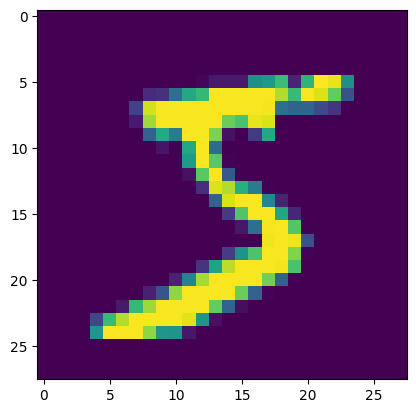

In [16]:
plt.imshow(v_img[0].view(28, 28) * 255)

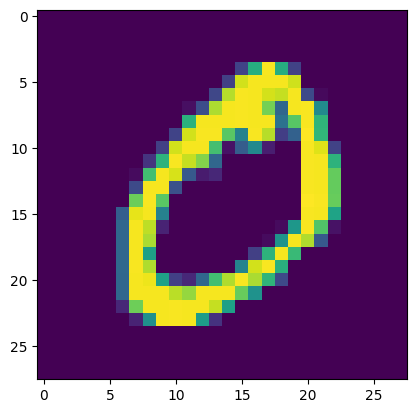

In [17]:
plt.imshow(v_img[1].view(28, 28) * 255)

In [18]:
def train(model, tr_ds_loader):
    model.train()
    for (x, y) in tr_ds_loader:
        data = x.view(-1, 28*28).to(DEVICE)
        target = x.view(-1, 28*28).to(DEVICE)
        label = y.to(DEVICE)

        _, decoded = model(data)

        loss = criterion(decoded, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [19]:
v_img.data.numpy().shape # v_img = tr_ds.data[:5].view(-1, 28*28)

(5, 784)

1회


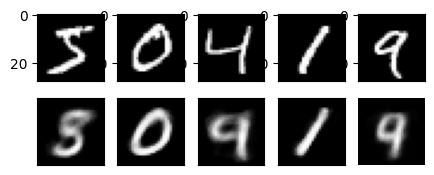

2회


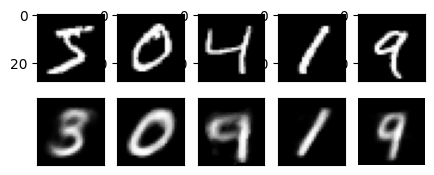

3회


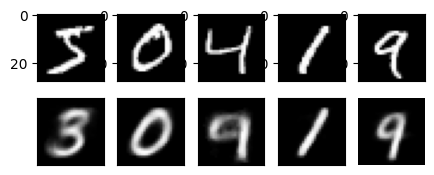

4회


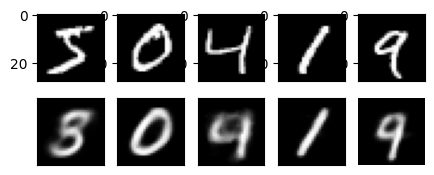

5회


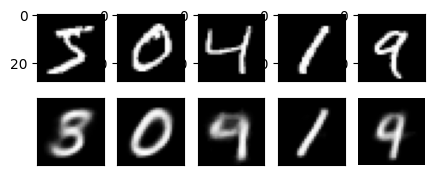

6회


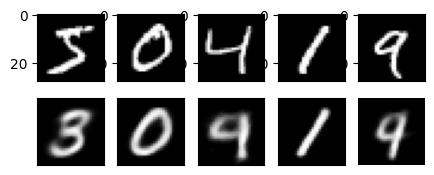

7회


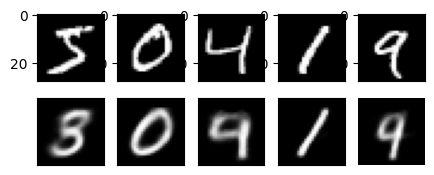

8회


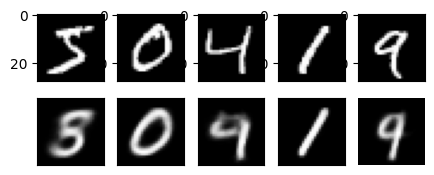

9회


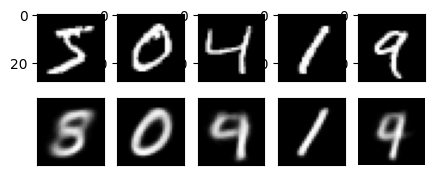

10회


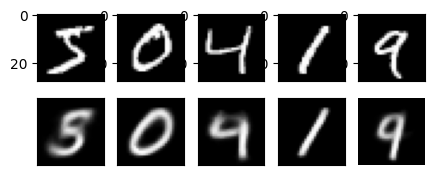

In [20]:
for epoch in range(1, EPOCHS+1):
    train(autoencoder, tr_ds_loader)

    tt_x = v_img.to(DEVICE)
    _, dc_data = autoencoder(tt_x)

    fig, a = plt.subplots(2, 5, figsize=(5, 2))
    print(f'{epoch}회')

    for i in range(5):
        img = v_img.data.numpy()[i].reshape(28, 28)
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(())
        a[1][i].set_yticks(())
    
    for i in range(5):
        img = dc_data.to('cpu').data.numpy()[i].reshape(28, 28)
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.axis('off')
    plt.show()

# FashionMNIST 데이터를 이용하여 오토인코더 설계 및 학습

In [2]:
# 0. 작업 준비
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch.utils import data
from torchvision import datasets, transforms, utils
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

In [4]:
tr_ds = datasets.FashionMNIST(root='../data/',
                              train=True,
                              download=True,
                              transform=transform)

In [6]:
BATCH_SIZE = 60000
tr_ds_loader = torch.utils.data.DataLoader(
    dataset=tr_ds,
    batch_size=BATCH_SIZE,
    shuffle=False
)

img, _ = next(iter(tr_ds_loader))
img.shape, img.mean(), img.std()

(torch.Size([60000, 1, 28, 28]), tensor(0.2860), tensor(0.3530))

In [7]:
BATCH_SIZE=64
EPOCHS=10

In [8]:
# 1. 데이터 준비
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # 데이터 증강(노이즈 삽입)
    transforms.ToTensor(), # 입력 데이터 정리
    transforms.Normalize((0.2860,), (0.3530,))
]) # 데이터 사용 방식 내용 설정

tr_ds_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(root='../data/',
                              train=True,
                              download=False,
                              transform=transform),
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=2)
tt_ds_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(root='../data/',
                              train=False,
                              download=False,
                              transform=transform),
                              batch_size=BATCH_SIZE,
                              shuffle=True)

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid() # 출력 범위 0 ~ 1 로 클리핑
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [10]:
autoencoder = AutoEncoder().to(DEVICE)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [11]:
v_img = tr_ds.data[:5].view(-1, 28*28)
v_img = v_img.type(torch.FloatTensor)/255.
v_img.shape

torch.Size([5, 784])

In [16]:
def train(model, tr_ds_loader):
    model.train()
    for (x, y) in tr_ds_loader:
        data = x.view(-1, 28*28).to(DEVICE)
        target = x.view(-1, 28*28).to(DEVICE)
        label = y.to(DEVICE)

        _, decoded = model(data)

        loss = criterion(decoded, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

1회


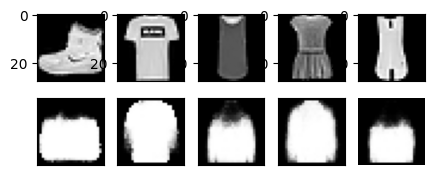

2회


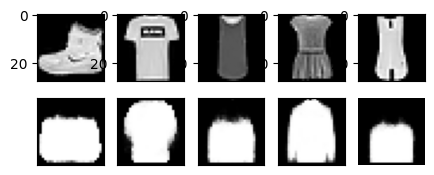

3회


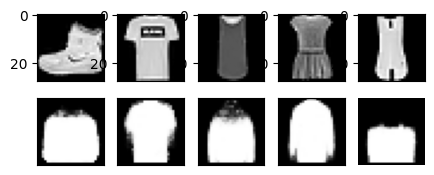

4회


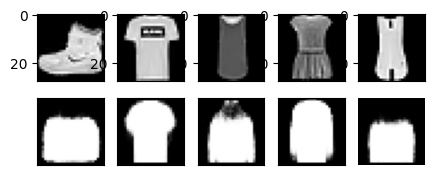

5회


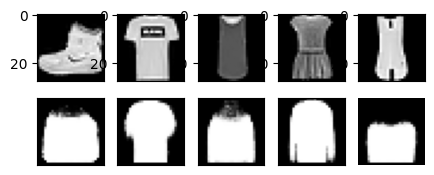

6회


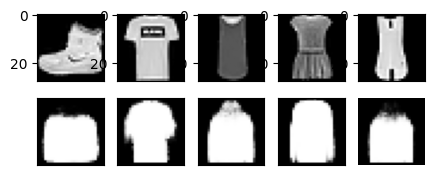

7회


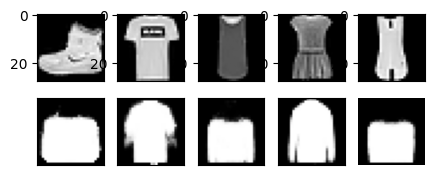

8회


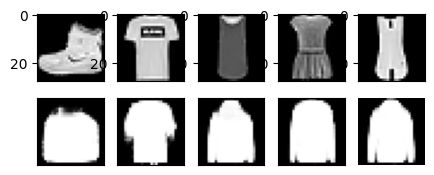

9회


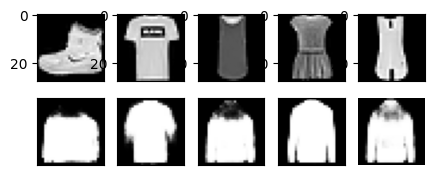

10회


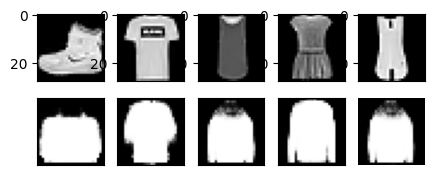

In [17]:
for epoch in range(1, EPOCHS+1):
    train(autoencoder, tr_ds_loader)

    tt_x = v_img.to(DEVICE)
    _, dc_data = autoencoder(tt_x)

    fig, a = plt.subplots(2, 5, figsize=(5, 2))
    print(f'{epoch}회')

    for i in range(5):
        img = v_img.data.numpy()[i].reshape(28, 28)
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(())
        a[1][i].set_yticks(())
    
    for i in range(5):
        img = dc_data.to('cpu').data.numpy()[i].reshape(28, 28)
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.axis('off')
    plt.show()

# Denoising Model

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import FashionMNIST
from torchvision import transforms

from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 64
EPOCHS = 10

In [4]:
tr_ds = FashionMNIST(
    root='../data/',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
tr_ds_loader = DataLoader(
    tr_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [6]:
autoencoder = AutoEncoder().to(DEVICE)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [7]:
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noise_img = img + noise
    return noise_img

In [14]:
def train(model, pbar):
    model.train()
    total_loss = 0
    total = 0
    for (x, y) in pbar:
        noise_img = add_noise(x)
        data, target = noise_img.view(-1, 28*28).to(DEVICE), x.view(-1, 28*28).to(DEVICE)

        optimizer.zero_grad()
        _, decoded = model(data)

        loss = criterion(decoded, target)
        loss.backward()
        optimizer.step()

        total += len(x)
        total_loss += loss.item() * len(x)
        avg_loss = total_loss / total

        pbar.set_postfix({
            'train_loss': f'{avg_loss:.4f}'})

In [15]:
for epoch in range(1, EPOCHS):
    pbar = tqdm(tr_ds_loader,
                desc=f'[EPOCH: {epoch}/{EPOCHS}]')
    train(autoencoder, pbar)


[EPOCH: 9/10]: 100%|██████████| 938/938 [00:12<00:00, 77.22it/s, train_loss=0.0234]


In [16]:
tt_ds = FashionMNIST(
    root='../data/',
    train=False,
    download=False,
    transform=transforms.ToTensor(),
)

tt_ds_loader = DataLoader(
    tt_ds,
    batch_size=BATCH_SIZE,
    shuffle=False
)

sample_data = tt_ds.data[0].view(-1, 28*28)
sample_data = sample_data.type(torch.FloatTensor) / 255.
oj_data = sample_data[0]
noise_data = add_noise(oj_data).to(DEVICE)
_, output = autoencoder(noise_data)

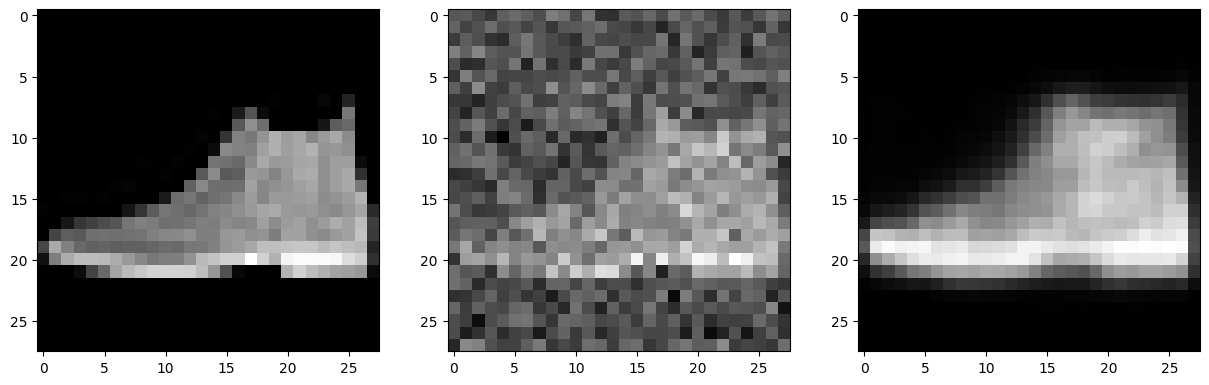

In [19]:
fig, a = plt.subplots(1, 3, figsize=(15, 15))
oj_img = oj_data.to('cpu').data.numpy().reshape(28, 28)
noisy_img = noise_data.to('cpu').data.numpy().reshape(28, 28)
out_img = output.to('cpu').data.numpy().reshape(28, 28)
# oj_img.shape, noisy_img.shape, out_img.shape
a[0].imshow(oj_img, cmap='gray')
a[1].imshow(noisy_img, cmap='gray')
a[2].imshow(out_img, cmap='gray')

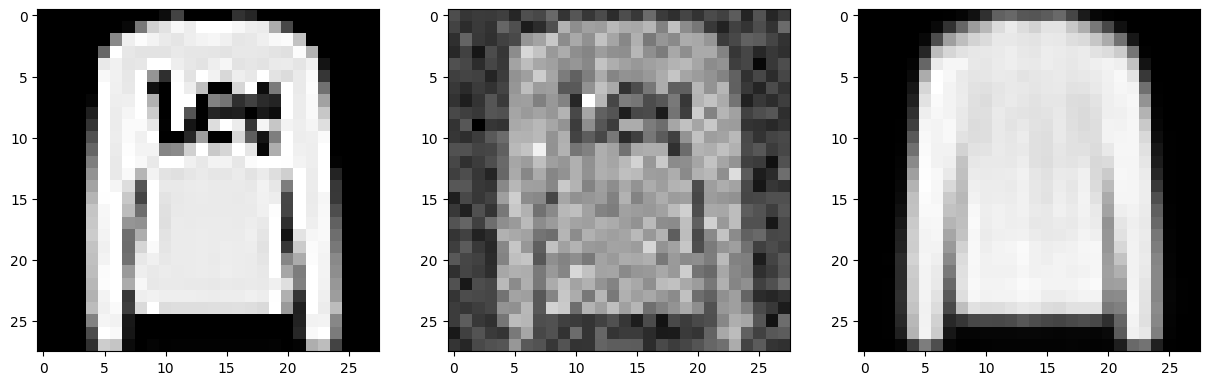

In [23]:
sample_data = tt_ds.data[1].view(-1, 28*28)
sample_data = sample_data.type(torch.FloatTensor) / 255.
oj_data = sample_data[0]
noise_data = add_noise(oj_data).to(DEVICE)
_, output = autoencoder(noise_data)
fig, a = plt.subplots(1, 3, figsize=(15, 15))
oj_img = oj_data.to('cpu').data.numpy().reshape(28, 28)
noisy_img = noise_data.to('cpu').data.numpy().reshape(28, 28)
out_img = output.to('cpu').data.numpy().reshape(28, 28)
# oj_img.shape, noisy_img.shape, out_img.shape
a[0].imshow(oj_img, cmap='gray')
a[1].imshow(noisy_img, cmap='gray')
a[2].imshow(out_img, cmap='gray')

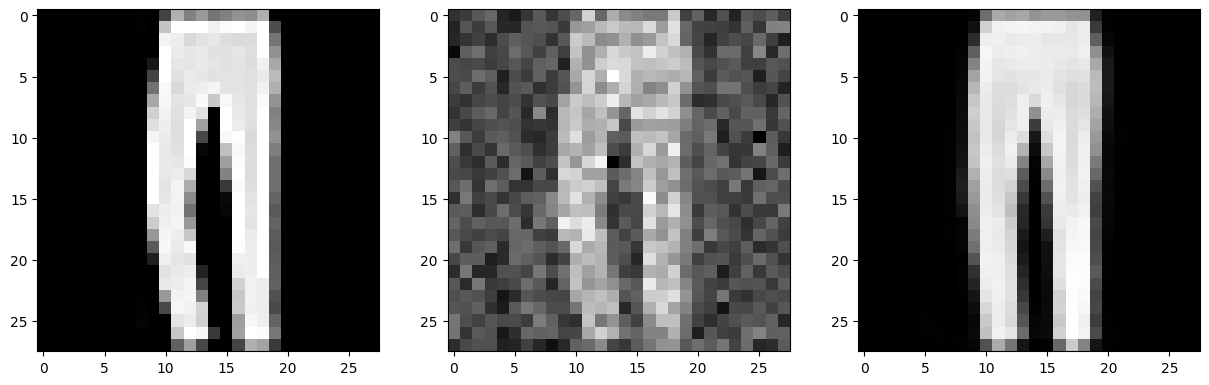

In [24]:
sample_data = tt_ds.data[2].view(-1, 28*28)
sample_data = sample_data.type(torch.FloatTensor) / 255.
oj_data = sample_data[0]
noise_data = add_noise(oj_data).to(DEVICE)
_, output = autoencoder(noise_data)
fig, a = plt.subplots(1, 3, figsize=(15, 15))
oj_img = oj_data.to('cpu').data.numpy().reshape(28, 28)
noisy_img = noise_data.to('cpu').data.numpy().reshape(28, 28)
out_img = output.to('cpu').data.numpy().reshape(28, 28)
# oj_img.shape, noisy_img.shape, out_img.shape
a[0].imshow(oj_img, cmap='gray')
a[1].imshow(noisy_img, cmap='gray')
a[2].imshow(out_img, cmap='gray')

# GAN

In [26]:
transform = transforms.Compose([transforms.ToTensor()])
tr_ds = FashionMNIST(
    root='../data/',
    train=True,
    download=False,
    transform=transform)

In [27]:
BATCH_SIZE= 64

In [28]:
transfrom = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

tr_ds_loader = DataLoader(
    tr_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

In [29]:
G = nn.Sequential(
    nn.Linear(64, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 784),
    nn.Tanh()
)

D = nn.Sequential(
    nn.Linear(784, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

In [30]:
G = G.to(DEVICE)
D = D.to(DEVICE)

In [33]:
criterion = nn.BCELoss()
D_optimizer = optim.Adam(D.parameters(), lr=0.0002)
G_optimizer = optim.Adam(G.parameters(), lr=0.0002)

In [ ]:
EPOCHS = 30
for epoch in range(EPOCHS):
    pbar = tqdm(tr_ds_loader, desc=f'[EPOCH: {epoch}/{EPOCHS}]')
    for i, (x, _) in enumerate(pbar):
        # data = x.reshape(-1, 28*28).to(DEVICE)
        data = x.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        if data.shape[-1] != 784:
            continue
        
        r_label = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        f_label = torch.zeros(BATCH_SIZE, 1).to(DEVICE)
        # 1. 진짜 데이터 판별
        output = D(data)
        d_loss_real = criterion(output, r_label)
        real_sc = output

        z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
        f_data = G(z)

        # 2. 가짜 데이터 판별
        output = D(f_data)
        d_loss_fake = criterion(output, f_label)
        fake_sc = output

        d_loss = d_loss_real + d_loss_fake

        # 그래디언트 초기화
        G_optimizer.zero_grad()
        D_optimizer.zero_grad()

        # 생성 오차 도출
        f_data = G(z) # 새로운 계산 그래프를 만들기 위해 다시 forward (이전 backward에 사용된 그래프 재사용 방지)

        # 판별자 학습
        d_loss.backward()
        D_optimizer.step()
        
        output = D(f_data)
        g_loss = criterion(output, r_label) # 진짜로 인식해야 하므로 진짜 이미지랑 오차 확인

        # 그래디언트 초기화
        G_optimizer.zero_grad()
        D_optimizer.zero_grad()

        # 생성자 학습
        g_loss.backward()
        G_optimizer.step()

        pbar.set_postfix({
            'd_loss':f'{d_loss:.4f}',
            'f_loss':f'{g_loss:.4f}',
        })

    print(f'{epoch}회 d_loss{d_loss.item()}, g_loss{g_loss.item()} D(G(z)):{fake_sc.mean()} D(x):{real_sc.mean()}')

[EPOCH: 0/30]: 100%|██████████| 938/938 [00:12<00:00, 75.89it/s, d_loss=0.6780, f_loss=2.2169] 


0회 d_loss0.6779752969741821, g_loss2.216923713684082 D(G(z)):0.25154557824134827 D(x):0.7777284383773804


[EPOCH: 1/30]: 100%|██████████| 938/938 [00:14<00:00, 64.12it/s, d_loss=0.3354, f_loss=3.1906]


1회 d_loss0.3354169428348541, g_loss3.1906185150146484 D(G(z)):0.0793006494641304 D(x):0.8535215854644775


[EPOCH: 2/30]: 100%|██████████| 938/938 [00:16<00:00, 56.71it/s, d_loss=0.4677, f_loss=2.7691]


2회 d_loss0.4677487909793854, g_loss2.769075632095337 D(G(z)):0.2538064122200012 D(x):0.9392274022102356


[EPOCH: 3/30]: 100%|██████████| 938/938 [00:17<00:00, 53.04it/s, d_loss=0.2999, f_loss=4.1868]


3회 d_loss0.29988542199134827, g_loss4.186802387237549 D(G(z)):0.0792914628982544 D(x):0.9015262722969055


[EPOCH: 4/30]: 100%|██████████| 938/938 [00:16<00:00, 57.00it/s, d_loss=0.1001, f_loss=5.0182]


4회 d_loss0.10009826719760895, g_loss5.018182754516602 D(G(z)):0.05822145938873291 D(x):0.974154531955719


[EPOCH: 5/30]: 100%|██████████| 938/938 [00:16<00:00, 56.72it/s, d_loss=0.5721, f_loss=3.4587]


5회 d_loss0.5720919370651245, g_loss3.458651304244995 D(G(z)):0.19945329427719116 D(x):0.8598322868347168


[EPOCH: 6/30]: 100%|██████████| 938/938 [00:15<00:00, 60.95it/s, d_loss=0.3360, f_loss=3.2342]


6회 d_loss0.3360235095024109, g_loss3.2342095375061035 D(G(z)):0.12624529004096985 D(x):0.8983557224273682


[EPOCH: 7/30]: 100%|██████████| 938/938 [00:16<00:00, 57.66it/s, d_loss=0.3731, f_loss=3.3582]


7회 d_loss0.37306901812553406, g_loss3.358203411102295 D(G(z)):0.13171909749507904 D(x):0.9004604816436768


[EPOCH: 8/30]: 100%|██████████| 938/938 [00:15<00:00, 59.41it/s, d_loss=0.5714, f_loss=2.3942]


8회 d_loss0.5714106559753418, g_loss2.394214153289795 D(G(z)):0.26777514815330505 D(x):0.8963615894317627


[EPOCH: 9/30]: 100%|██████████| 938/938 [00:15<00:00, 59.58it/s, d_loss=0.7297, f_loss=2.5619]


9회 d_loss0.7296793460845947, g_loss2.56190824508667 D(G(z)):0.1922249048948288 D(x):0.8074203729629517


[EPOCH: 10/30]: 100%|██████████| 938/938 [00:17<00:00, 52.77it/s, d_loss=0.7206, f_loss=2.5186]


10회 d_loss0.7206196784973145, g_loss2.5185599327087402 D(G(z)):0.3109195828437805 D(x):0.884247362613678


[EPOCH: 11/30]: 100%|██████████| 938/938 [00:15<00:00, 59.74it/s, d_loss=0.2978, f_loss=3.7503]


11회 d_loss0.2978140413761139, g_loss3.7502923011779785 D(G(z)):0.11676304787397385 D(x):0.9114673733711243


[EPOCH: 12/30]: 100%|██████████| 938/938 [00:15<00:00, 62.43it/s, d_loss=0.6722, f_loss=2.4659]


12회 d_loss0.67221599817276, g_loss2.4659039974212646 D(G(z)):0.18108758330345154 D(x):0.7794739007949829


[EPOCH: 13/30]: 100%|██████████| 938/938 [00:15<00:00, 62.07it/s, d_loss=0.4703, f_loss=3.1895]


13회 d_loss0.47029146552085876, g_loss3.189491033554077 D(G(z)):0.12424932420253754 D(x):0.8216661214828491


[EPOCH: 14/30]: 100%|██████████| 938/938 [00:15<00:00, 62.36it/s, d_loss=0.4745, f_loss=2.8931]


14회 d_loss0.47446542978286743, g_loss2.8930811882019043 D(G(z)):0.111732617020607 D(x):0.8109180927276611


[EPOCH: 15/30]: 100%|██████████| 938/938 [00:15<00:00, 62.41it/s, d_loss=0.4800, f_loss=2.4894]


15회 d_loss0.4799744486808777, g_loss2.4893829822540283 D(G(z)):0.27571240067481995 D(x):0.942595899105072


[EPOCH: 16/30]: 100%|██████████| 938/938 [00:15<00:00, 62.46it/s, d_loss=0.5768, f_loss=2.9182]


16회 d_loss0.5767666101455688, g_loss2.9181880950927734 D(G(z)):0.22830747067928314 D(x):0.8282042741775513


[EPOCH: 17/30]: 100%|██████████| 938/938 [00:15<00:00, 61.87it/s, d_loss=0.3967, f_loss=3.5491]


17회 d_loss0.3966926038265228, g_loss3.5491421222686768 D(G(z)):0.11071475595235825 D(x):0.8519960641860962


[EPOCH: 18/30]: 100%|██████████| 938/938 [00:15<00:00, 60.51it/s, d_loss=0.6012, f_loss=2.9679]


18회 d_loss0.6011667847633362, g_loss2.967949151992798 D(G(z)):0.13856935501098633 D(x):0.7623212337493896


[EPOCH: 19/30]: 100%|██████████| 938/938 [00:16<00:00, 57.24it/s, d_loss=0.6162, f_loss=2.5724]


19회 d_loss0.6162478923797607, g_loss2.5723726749420166 D(G(z)):0.17368817329406738 D(x):0.7978867292404175


[EPOCH: 20/30]: 100%|██████████| 938/938 [00:16<00:00, 57.12it/s, d_loss=0.7338, f_loss=2.3832]


20회 d_loss0.7337840795516968, g_loss2.3832478523254395 D(G(z)):0.16810117661952972 D(x):0.785861611366272


[EPOCH: 21/30]: 100%|██████████| 938/938 [00:16<00:00, 57.41it/s, d_loss=0.7085, f_loss=2.9972]


21회 d_loss0.7085162401199341, g_loss2.997161388397217 D(G(z)):0.1890193670988083 D(x):0.7977845668792725


[EPOCH: 22/30]: 100%|██████████| 938/938 [00:16<00:00, 55.52it/s, d_loss=0.6184, f_loss=2.6291]


22회 d_loss0.6183818578720093, g_loss2.6291496753692627 D(G(z)):0.23150977492332458 D(x):0.8186938166618347


[EPOCH: 23/30]: 100%|██████████| 938/938 [00:17<00:00, 52.74it/s, d_loss=0.4308, f_loss=3.1825]


23회 d_loss0.43078547716140747, g_loss3.182478427886963 D(G(z)):0.10209542512893677 D(x):0.8077471256256104


[EPOCH: 24/30]: 100%|██████████| 938/938 [00:16<00:00, 55.67it/s, d_loss=0.8623, f_loss=1.9670]


24회 d_loss0.8622951507568359, g_loss1.966970443725586 D(G(z)):0.23014578223228455 D(x):0.7164621353149414


[EPOCH: 25/30]: 100%|██████████| 938/938 [00:16<00:00, 57.59it/s, d_loss=0.4357, f_loss=3.6108]


25회 d_loss0.4356916844844818, g_loss3.6108040809631348 D(G(z)):0.08885045349597931 D(x):0.8122309446334839


[EPOCH: 26/30]: 100%|██████████| 938/938 [00:15<00:00, 59.26it/s, d_loss=0.2901, f_loss=3.1258]


26회 d_loss0.2900683283805847, g_loss3.1257824897766113 D(G(z)):0.0984354093670845 D(x):0.8821211457252502


[EPOCH: 27/30]: 100%|██████████| 938/938 [00:15<00:00, 60.93it/s, d_loss=0.7065, f_loss=2.5945]


27회 d_loss0.7065019607543945, g_loss2.594451904296875 D(G(z)):0.18220219016075134 D(x):0.7700111865997314


[EPOCH: 28/30]: 100%|██████████| 938/938 [00:16<00:00, 58.37it/s, d_loss=0.7960, f_loss=2.4352]


28회 d_loss0.7959564328193665, g_loss2.435157060623169 D(G(z)):0.13748911023139954 D(x):0.6968629360198975


[EPOCH: 29/30]: 100%|██████████| 938/938 [00:17<00:00, 53.79it/s, d_loss=0.9685, f_loss=2.5324]

29회 d_loss0.9684501886367798, g_loss2.532353401184082 D(G(z)):0.2736738324165344 D(x):0.7295554876327515


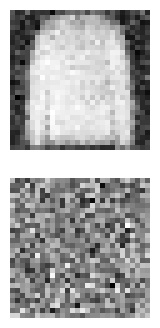

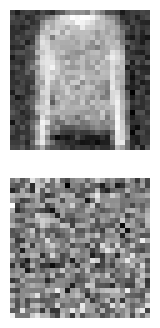

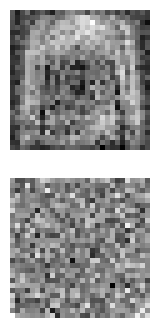

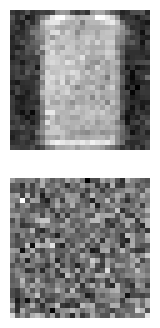

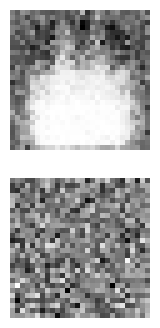

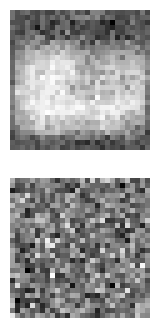

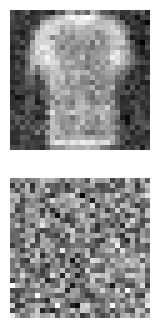

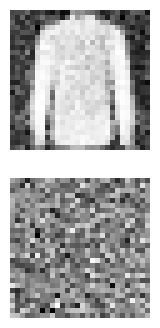

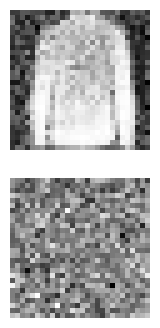

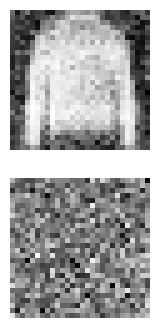

In [40]:
z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
ck_img1 = G(z)

G1 = nn.Sequential(
    nn.Linear(64, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 784),
    nn.Tanh()
)
G1 = G1.to(DEVICE)

ck_img2 = G1(z)

for i in range(10):
    plt.figure(figsize=(2, 4))

    plt.subplot(2, 1, 1)
    plt.imshow(ck_img1[i].detach().cpu().numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')

    plt.subplot(2, 1, 2)
    plt.imshow(ck_img2[i].detach().cpu().numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')

    plt.show()